## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.color import rgb2ycbcr
from torch.utils.data import Dataset, DataLoader

## Loading Image

In [3]:
image = plt.imread('baby.png')
image = rgb2ycbcr(image)[:, :, 0]

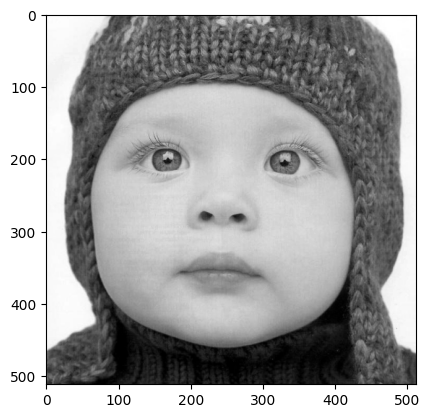

In [4]:
plt.imshow(image, cmap='gray')  # TODO: surface plot

## Generating Dataset

In [5]:
class PixelDataset(Dataset):
    def __init__(self, image):
        x1_rng = np.linspace(0, 1, image.shape[0])
        x2_rng = np.linspace(0, 1, image.shape[1])
        x1, x2 = np.meshgrid(x1_rng, x2_rng)
        x1 = x1.reshape(-1, 1)
        x2 = x2.reshape(-1, 1)
        self.X = np.concatenate((x1, x2), axis=-1)
        self.Y = image.reshape(-1) / 255.0

    def __len__(self):
        return self.Y.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.Y[idx], dtype=torch.float32)
        return x, y

## Training The Model

In [31]:
class ImageNeRF(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, hidden_dim//4),
            nn.ReLU(),
            nn.Linear(hidden_dim//4, 1),
        )
        
    def forward(self, x):
        return self.net(x)

In [32]:
model = ImageNeRF(hidden_dim=600)

In [37]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
num_params = sum([np.prod(p.size()) for p in model_parameters])
num_pixels = image.shape[0] * image.shape[1]
print(f'# Params: {num_params}, # Pixel: {num_pixels}, Ratio: {100*(num_params/num_pixels):.2f}%')

# Params: 451951, # Pixel: 262144, Ratio: 172.41%


In [38]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [39]:
dataset = PixelDataset(image)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [40]:
for epoch in range(30):
    mean_loss = 0.0
    for x, y in dataloader:
        y_hat = model(x)
        loss = loss_fn(y_hat.squeeze(), y.squeeze())
        mean_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    mean_loss /= len(dataloader)
    print(f'EPOCH: {epoch}, LOSS: {mean_loss:.5f}')

EPOCH: 0, LOSS: 0.00458
EPOCH: 1, LOSS: 0.00415
EPOCH: 2, LOSS: 0.00386
EPOCH: 3, LOSS: 0.00362
EPOCH: 4, LOSS: 0.00346
EPOCH: 5, LOSS: 0.00344
EPOCH: 6, LOSS: 0.00332
EPOCH: 7, LOSS: 0.00321
EPOCH: 8, LOSS: 0.00321
EPOCH: 9, LOSS: 0.00303
EPOCH: 10, LOSS: 0.00295
EPOCH: 11, LOSS: 0.00296
EPOCH: 12, LOSS: 0.00283
EPOCH: 13, LOSS: 0.00281
EPOCH: 14, LOSS: 0.00275
EPOCH: 15, LOSS: 0.00270
EPOCH: 16, LOSS: 0.00266
EPOCH: 17, LOSS: 0.00271
EPOCH: 18, LOSS: 0.00263
EPOCH: 19, LOSS: 0.00255
EPOCH: 20, LOSS: 0.00251
EPOCH: 21, LOSS: 0.00250
EPOCH: 22, LOSS: 0.00246
EPOCH: 23, LOSS: 0.00242
EPOCH: 24, LOSS: 0.00240
EPOCH: 25, LOSS: 0.00240
EPOCH: 26, LOSS: 0.00237
EPOCH: 27, LOSS: 0.00233
EPOCH: 28, LOSS: 0.00232
EPOCH: 29, LOSS: 0.00228


## Evaluating

In [41]:
x = torch.tensor(dataset.X, dtype=torch.float32)

In [42]:
with torch.no_grad():
    y_hat = model(x)

In [43]:
image_hat = y_hat.view(image.shape).numpy()

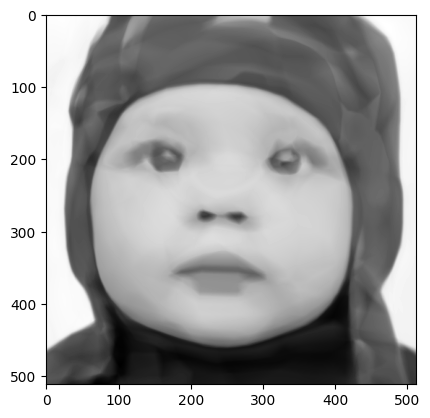

In [44]:
plt.imshow(image_hat, cmap='gray')